In [125]:
import tensorflow as tf  # Import TensorFlow library
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Import ImageDataGenerator for image preprocessing
from keras.applications.vgg16 import VGG16  # Import VGG16 model
from keras.optimizers import Adam  # Import Adam optimizer
from keras.models import Model, load_model  # Import Sequential and Model for defining neural network models
import numpy as np
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, GlobalAveragePooling2D  # Import various layers from Keras
import warnings  # Import warnings module
import os  # Import os module
from sklearn.utils import compute_class_weight
warnings.filterwarnings('ignore')  # Ignore warnings
import matplotlib.pyplot as plt  # Import matplotlib for plotting
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score  # Import various metrics for model evaluation
import seaborn as sns  # Import seaborn for confusion matrix visualization


In [192]:
BATCH_SIZE = 16  # Define batch size for training

# Data augmentation and preprocessing for training set
train_datagen = ImageDataGenerator(
    rotation_range=90,  # Random rotation between 0 and 90 degrees
    rescale=1/255.,  # Rescale pixel values to the range [0,1]
    brightness_range=[0.5, 1.0],  # Random brightness adjustment
    width_shift_range=0.5,  # Random horizontal shift
    height_shift_range=0.5,  # Random vertical shift
    horizontal_flip=True,  # Random horizontal flip
    vertical_flip=True,  # Random vertical flip
    validation_split=0.15  # Fraction of data to reserve for validation
)

# Data preprocessing for testing set
test_datagen = ImageDataGenerator(
    rescale=1/255.
)


In [175]:
# Get list of classes from the 'train' directory and sort them alphabetically
class_subset = sorted(os.listdir('train'))

In [193]:
# Create a data generator for the training set
train_generator = train_datagen.flow_from_directory(
                                'train',  # Directory containing training images
                                target_size=(224, 224),  # Resize images to 224x224 pixels
                                class_mode='binary',  # Binary classification
                                classes=class_subset,  # List of classes
                                subset='training',  # Subset of data (training)
                                batch_size=BATCH_SIZE,  # Batch size
                                shuffle=True,  # Shuffle data
                                seed=42  # Random seed for reproducibility
)

# Create a data generator for the validation set
valid_generator = train_datagen.flow_from_directory(
                                'train',
                                target_size=(224, 224),
                                class_mode='binary',
                                classes=class_subset, 
                                subset='validation',  # Subset of data (validation)
                                batch_size=BATCH_SIZE,
                                shuffle=True,
                                seed=42
)

# Create a data generator for the test set
test_generator = test_datagen.flow_from_directory(
                                'test',
                                target_size=(224, 224),
                                class_mode=None,  # Do not return class labels
                                classes=class_subset,
                                batch_size=1,  # Batch size (set to 1 for prediction)
                                shuffle=False,  # Do not shuffle data
                                seed=42
)


Found 406 images belonging to 2 classes.
Found 70 images belonging to 2 classes.
Found 499 images belonging to 2 classes.


In [177]:
# Get the class indices from the training generator
class_indices = train_generator.class_indices  # Get class indices

# Print the class indices
print("Class Indices:", class_indices)

# Inverse the dictionary to map indices to class names
inverse_class_indices = {v: k for k, v in class_indices.items()}

# Print the mapping
print("Class 0:", inverse_class_indices[0])
print("Class 1:", inverse_class_indices[1]) 


Class Indices: {'fake': 0, 'real': 1}
Class 0: fake
Class 1: real


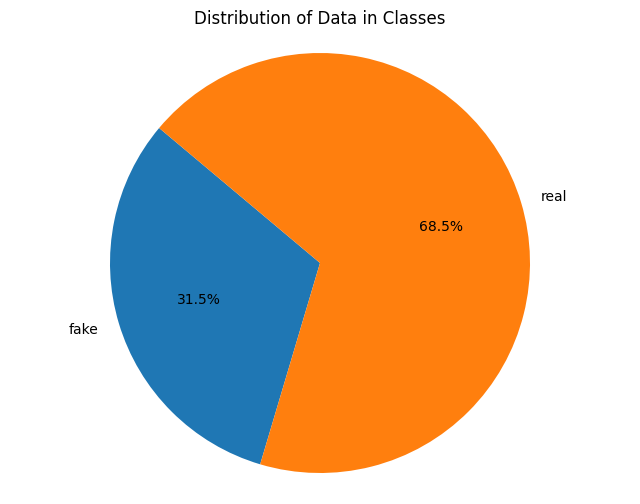

In [178]:
class_counts = np.bincount(train_generator.classes) + np.bincount(valid_generator.classes)  # Count samples in each class

# Define class names
class_names = ['fake', 'real']  # Define class names

# Plot pie chart
plt.figure(figsize=(8, 6))
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=140)  # Plot pie chart with percentages and labels
plt.title('Distribution of Data in Classes')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

[1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1.]


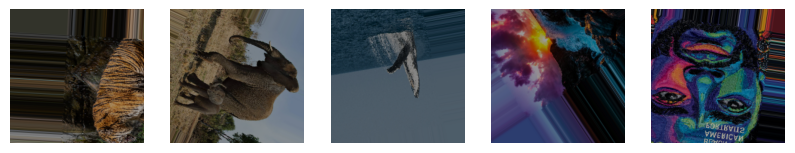

In [200]:
# Generate a batch of augmented images from the train generator
augmented_images, _ = next(train_generator)

# Plot the first 5 augmented images
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i+1) 
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.show()


In [345]:
input_shape = (224, 224, 3)  # Define the input shape for the model

# Define the Adam optimizer with a learning rate of 0.001
optim_1 = Adam(learning_rate=0.001)


In [346]:
# Calculate the number of steps per epoch for training data
n_steps = train_generator.samples // BATCH_SIZE

# Calculate the number of steps per epoch for validation data
n_val_steps = valid_generator.samples // BATCH_SIZE

# Define the number of epochs
n_epochs = 100


In [347]:
n_steps, n_val_steps

(25, 4)

In [380]:
#I have tried many models including just CNN and FCNN. Transfer learning works best due to limited data size. 
# Amongst transfer learning models, this model performed best.

# Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
base_model.trainable = False  # Freeze the weights of the base model

# Define the input and output of the base model
input = base_model.input
x = base_model.output

# Flatten or pool the output of the base model
x = GlobalAveragePooling2D()(x)  # You can use Flatten or GlobalAveragePooling2D, depending on your requirements

# Add Dense layers with ReLU activation
x = Dense(2048, activation='relu')(x)
x = Dense(2048, activation='relu')(x)

# Output layer
output = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=input, outputs=output)


In [349]:
save_name = 'VGG_Linear_2_Relu_2048'  # Define the name for saving the model

In [350]:
# Compile the model with the specified optimizer, loss function, and metrics
model.compile(optimizer=optim_1,  # Optimizer
              loss='binary_crossentropy',  # Loss function for binary classification
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])

In [381]:
# Print a summary of the model architecture
model.summary()

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_16     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 2048)           │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,963,713 (76.16 MB)

 Trainable params: 5,249,025 (20.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [352]:
# Define ModelCheckpoint callback to save the best weights during training

tl_checkpoint_1 = ModelCheckpoint(
    filepath=f'models/{save_name}.weights.best.keras',
    save_best_only=True,  # Save only the best model weights
    verbose=1
)

In [353]:
# Define EarlyStopping callback to stop training when validation loss stops improving

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,  # Restore best model weights upon early stopping
    mode='min'
)

In [354]:
# Calculate class weights based on class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',  # Use balanced class weights that handles class imbalances
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Convert class weights to dictionary format
class_weights_dict = dict(enumerate(class_weights))


In [355]:
vgg_history = model.fit(train_generator,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=valid_generator,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            class_weight = class_weights_dict,
                            callbacks=[tl_checkpoint_1, early_stop],
                            verbose=1)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5293 - loss: 0.8577 - precision_15: 0.6797 - recall_15: 0.5852
Epoch 1: val_loss improved from inf to 0.65864, saving model to models/VGG_Linear_2_Relu_1024.weights.best.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 101s 4s/step - accuracy: 0.5263 - loss: 0.8546 - precision_15: 0.6787 - recall_15: 0.5792 - val_accuracy: 0.7188 - val_loss: 0.6586 - val_precision_15: 0.7414 - val_recall_15: 0.9348
Epoch 2/100
 1/25 ━━━━━━━━━━━━━━━━━━━━ 1:06 3s/step - accuracy: 0.6875 - loss: 0.7347 - precision_15: 0.6667 - recall_15: 1.0000
Epoch 2: val_loss improved from 0.65864 to 0.34636, saving model to models/VGG_Linear_2_Relu_1024.weights.best.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.6875 - loss: 0.3821 - precision_15: 0.6667 - recall_15: 1.0000 - val_accuracy: 0.5000 - val_loss: 0.3464 - val_precision_15: 0.4000 - val_recall_15: 1.0000
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6260 - loss: 0.6811 - precisi

## Model: VGG-16 Embeddings with 2 Dense Layers (2048 Neurons) and ReLU activation performs the best. We present the performance on test set.

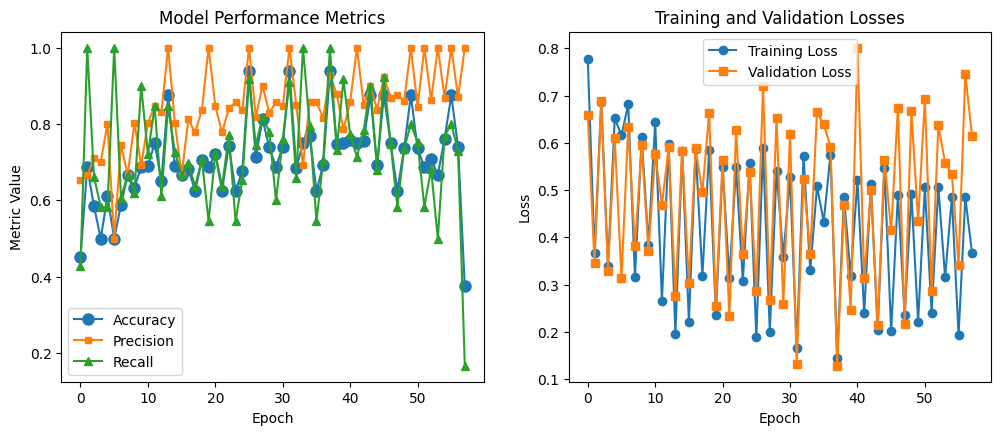

In [379]:
# Plotting with markers
plt.figure(figsize=(12, 10))

# First plot: Model performance metrics
plt.subplot(2, 2, 1)
plt.plot(vgg_history.history['accuracy'], label='Accuracy', marker='o', markersize=8)
plt.plot(vgg_history.history['precision_15'], label='Precision', marker='s', markersize=5)
plt.plot(vgg_history.history['recall_15'], label='Recall', marker='^')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Model Performance Metrics')
plt.legend()

# Second plot: Training and validation losses
plt.subplot(2, 2, 2)
plt.plot(vgg_history.history['loss'], label='Training Loss', marker='o')
plt.plot(vgg_history.history['val_loss'], label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

# Save and show the plot
plt.savefig(f'graphs/{save_name}.png')
plt.show()

In [383]:
# Generate predictions
model = load_model(r'models/{save_name}.weights.best.keras')
true_classes = test_generator.classes
vgg_preds = model.predict(test_generator)

499/499 ━━━━━━━━━━━━━━━━━━━━ 88s 176ms/step


In [ ]:
vgg_pred_classes = (vgg_preds > 0.5).astype(int)  # Threshold at 0.5

In [384]:
# Compute model accuracy
vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("Model Accuracy: {:.2f}%".format(vgg_acc * 100))

Model Accuracy: 73.15%


In [385]:
# Compute model precision
vgg_pred = precision_score(true_classes, vgg_pred_classes)
print("Model Precision: {:.2f}%".format(vgg_pred * 100))

Model Precision: 43.81%


In [386]:
# Compute model recall
vgg_rec = recall_score(true_classes, vgg_pred_classes)
print("Model Recall: {:.2f}%".format(vgg_rec * 100))

Model Recall: 77.27%


In [387]:
# Compute model F1 score
print("Model F1 Score: {:.2f}%".format( 2/((1/vgg_rec) + (1/vgg_pred)) * 100))

Model F1 Score: 55.92%


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.72      0.81       389
           1       0.44      0.77      0.56       110

    accuracy                           0.73       499
   macro avg       0.68      0.75      0.68       499
weighted avg       0.81      0.73      0.75       499



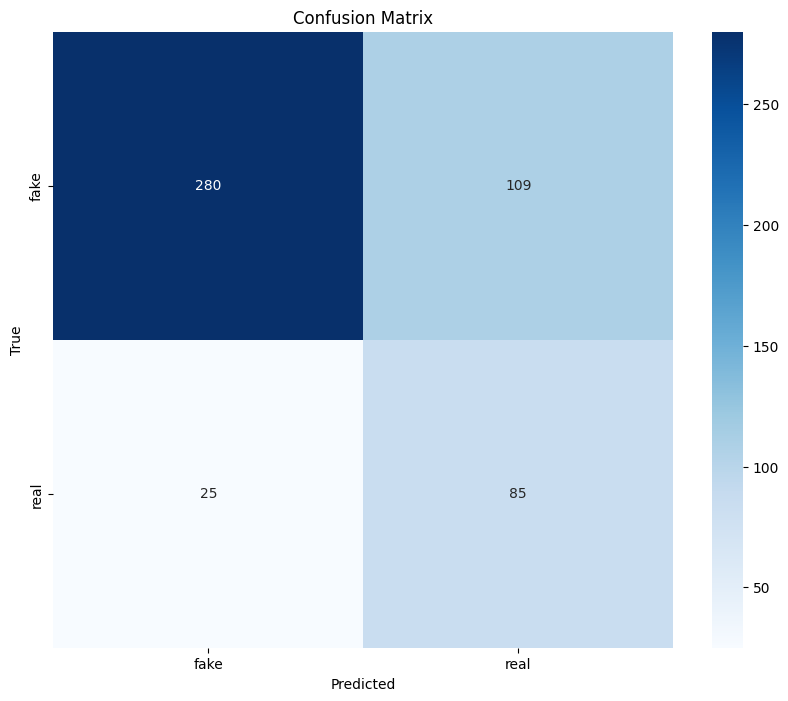

In [388]:
# Print classification report
print("Classification Report:")
print(classification_report(true_classes, vgg_pred_classes))

# Compute confusion matrix
conf_mat = confusion_matrix(true_classes, vgg_pred_classes)

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_indices.keys(), 
            yticklabels=class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.show()